In [15]:
# ============================================
# Regression vs Classification Forecasting
# 10 Stocks, Tree & Boosting Models
# Data Source: Stooq (no API key needed)
# ============================================

import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.svm import SVC

from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
    GradientBoostingRegressor,
    GradientBoostingClassifier,
)
from sklearn.preprocessing import StandardScaler
from scipy.stats import wilcoxon

In [17]:
# -----------------------------
# 1. Global configuration
# -----------------------------

# 10 diverse US stocks
tickers = ["AAPL", "MSFT", "AMZN", "KO", "JPM", "BAC", "XOM", "CVX", "BA", "CAT"]

cost_per_side = 0.0005    # 5 bps per trade side
theta_reg = 0.0005        # regression threshold (5 bps)
theta_cls = 0.05          # classification threshold (prob distance from 0.5)
annualization = 252       # trading days per year


In [19]:
# -----------------------------
# 2. Helper functions
# -----------------------------

def download_stooq(ticker):
    """
    Download daily OHLCV data for a US stock from Stooq.
    Uses the .us suffix convention, e.g. aapl.us for Apple.
    Returns DataFrame indexed by Date.
    """
    symbol = f"{ticker.lower()}.us"
    url = f"https://stooq.com/q/d/l/?s={symbol}&i=d"
    try:
        df = pd.read_csv(url)
    except Exception as e:
        print(f"⚠️ Error downloading {ticker} from Stooq:", e)
        return None

    if df.empty:
        print(f"⚠️ No data for {ticker}, skipping...")
        return None

    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date")
    df = df.sort_index()

    # Columns from Stooq: Date, Open, High, Low, Close, Volume
    # Already correctly named, but standardize just in case
    df = df.rename(columns={
        "Open": "Open",
        "High": "High",
        "Low": "Low",
        "Close": "Close",
        "Volume": "Volume"
    })

    return df


def sharpe_ratio(returns, freq=252):
    """
    Annualized Sharpe ratio for series of daily returns.
    """
    returns = pd.Series(returns).dropna()
    if len(returns) == 0:
        return np.nan
    mu = returns.mean() * freq
    sigma = returns.std() * np.sqrt(freq)
    return mu / sigma if sigma != 0 else np.nan


def max_drawdown(equity_curve):
    """
    Maximum drawdown of cumulative equity curve.
    """
    equity_curve = pd.Series(equity_curve).dropna()
    if len(equity_curve) == 0:
        return np.nan
    roll_max = equity_curve.cummax()
    dd = equity_curve / roll_max - 1.0
    return dd.min()


def pnl_from_positions(pos, ret, cost):
    """
    Compute daily net PnL from positions and returns.
    Positions act with 1-day lag (enter at t, earn return at t+1).
    Transaction cost based on position turnover * cost_per_side.
    """
    pos, ret = pos.align(ret, join="inner")
    # use yesterday's position to earn today's return
    gross = pos.shift(1) * ret
    gross = gross.fillna(0)

    turnover = pos.diff().abs().fillna(0)
    tc = turnover * cost
    net = gross - tc
    return net


def build_positions_from_reg(pred_series, threshold):
    """
    Long/short/flat from regression predicted return.
    > threshold → long
    < -threshold → short
    otherwise flat.
    """
    pred = pd.Series(pred_series)
    pos = np.where(pred > threshold, 1,
          np.where(pred < -threshold, -1, 0))
    return pd.Series(pos, index=pred.index)


def build_positions_from_prob(prob_series, theta):
    """
    Long/short/flat from classification probability P(up).
    > 0.5 + theta → long
    < 0.5 - theta → short
    otherwise flat.
    """
    p = pd.Series(prob_series)
    pos = np.where(p > 0.5 + theta, 1,
          np.where(p < 0.5 - theta, -1, 0))
    return pd.Series(pos, index=p.index)


def summarize_pnl(pnl_series):
    """
    Summary stats for a PnL series:
    Sharpe, max drawdown, total cumulative return.
    """
    pnl_series = pd.Series(pnl_series).dropna()
    if len(pnl_series) == 0:
        return {"sharpe": np.nan, "max_dd": np.nan, "total_ret": np.nan}
    equity = pnl_series.cumsum()
    return {
        "sharpe": sharpe_ratio(pnl_series, annualization),
        "max_dd": max_drawdown(equity),
        "total_ret": equity.iloc[-1],
    }

In [21]:
# -----------------------------
# 3. Feature engineering
# -----------------------------

def feature_engineering(price_df):
    """
    Build features & targets for one ticker using its own data only.
    Features:
      - lagged returns
      - rolling volatility
      - range-based volatility
      - moving averages & spread
      - drawdown
      - day-of-week & month dummies
    Targets:
      - y_reg: next-day return (regression)
      - y_cls_dir: next-day direction (classification)
    """
    df = price_df.copy()
    df = df.sort_index()

    # daily log return
    df["ret_1d"] = np.log(df["Close"] / df["Close"].shift(1))

    # targets
    df["y_reg"] = df["ret_1d"].shift(-1)
    df["y_cls_dir"] = (df["y_reg"] > 0).astype(int)

    # lagged returns
    for lag in [1, 2, 3, 4, 5]:
        df[f"ret_lag_{lag}"] = df["ret_1d"].shift(lag)

    # rolling volatility
    df["vol_20"] = df["ret_1d"].rolling(20).std()
    df["vol_60"] = df["ret_1d"].rolling(60).std()

    # realized range
    df["range_log"] = np.log(df["High"] / df["Low"])

    # moving averages
    df["sma_10"] = df["Close"].rolling(10).mean()
    df["sma_50"] = df["Close"].rolling(50).mean()
    df["sma_10_50_spread"] = df["sma_10"] - df["sma_50"]

    # drawdown vs 60-day high
    rolling_max_60 = df["Close"].rolling(60).max()
    df["dd_60"] = df["Close"] / rolling_max_60 - 1.0

    # seasonality
    df["dow"] = df.index.dayofweek
    df["month"] = df.index.month
    df = pd.get_dummies(df, columns=["dow", "month"], drop_first=True)

    # drop initial NaNs
    df = df.dropna()

    # feature columns
    feature_cols = [
        c for c in df.columns
        if (
            c.startswith("ret_lag_") or
            c.startswith("vol_") or
            c in ["range_log", "sma_10", "sma_50",
                  "sma_10_50_spread", "dd_60"] or
            c.startswith("dow_") or
            c.startswith("month_")
        )
    ]

    X = df[feature_cols].copy()
    y_reg = df["y_reg"].copy()
    y_cls = df["y_cls_dir"].copy()
    ret = df["ret_1d"].copy()

    return df, X, y_reg, y_cls, ret, feature_cols


In [23]:
# -----------------------------
# 4. Rolling walk-forward (with tuning + SVM)
# -----------------------------

def rolling_walk_forward(X, y_reg, y_cls, ret, dates,
                         first_train_years=5, test_years=1):
    """
    Rolling walk-forward evaluation for one ticker.
    - first_train_years: length of first training window
    - test_years: length of each subsequent test window
    Uses hyperparameter tuning (GridSearchCV with TimeSeriesSplit)
    and compares regression vs classification models, including SVM.
    Returns dict with concatenated PnL series per model.
    """
    results = {
        "pnl_linreg": [],
        "pnl_ridge": [],
        "pnl_rf_reg": [],
        "pnl_gb_reg": [],
        "pnl_logit": [],
        "pnl_rf_clf": [],
        "pnl_gb_clf": [],
        "pnl_svm_clf": [],   # NEW: SVM classifier
    }

    dates = pd.DatetimeIndex(dates)
    start_train = dates.min()
    current_train_end = start_train + pd.DateOffset(years=first_train_years)
    last_date = dates.max()

    feature_cols = X.columns

    # -----------------------------
    # Hyperparameter grids
    # -----------------------------
    param_grids = {
        "ridge": {
            "alpha": [0.1, 1.0, 10.0],
        },
        "rf_reg": {
            "n_estimators": [100, 300],
            "max_depth": [3, 6, None],
            "min_samples_leaf": [10, 20],
            "max_features": ["sqrt", None],
        },
        "gb_reg": {
            "n_estimators": [100, 300],
            "learning_rate": [0.05, 0.1],
            "max_depth": [2, 3],
            "subsample": [0.8, 1.0],
        },
        "logit": {
            "C": [0.1, 1.0, 10.0],
        },
        "rf_clf": {
            "n_estimators": [100, 300],
            "max_depth": [3, 6, None],
            "min_samples_leaf": [10, 20],
            "max_features": ["sqrt", None],
        },
        "gb_clf": {
            "n_estimators": [100, 300],
            "learning_rate": [0.05, 0.1],
            "max_depth": [2, 3],
            "subsample": [0.8, 1.0],
        },
        "svm": {
            "C": [0.1, 1.0, 10.0],
            "gamma": ["scale", "auto"],
            "kernel": ["rbf"],
        },
    }

    while current_train_end < last_date:
        train_mask = (dates >= start_train) & (dates <= current_train_end)
        test_mask = (dates > current_train_end) & (dates <= current_train_end + pd.DateOffset(years=test_years))
        test_dates = dates[test_mask]
        if len(test_dates) == 0:
            break

        X_train, X_test = X.loc[train_mask, feature_cols], X.loc[test_mask, feature_cols]
        y_reg_train, y_reg_test = y_reg[train_mask], y_reg[test_mask]
        y_cls_train, y_cls_test = y_cls[train_mask], y_cls[test_mask]
        ret_test = ret[test_mask]

        # scale features (for models that need it)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # time-series aware CV
        tscv = TimeSeriesSplit(n_splits=3)

        # ---------- Regression models ----------

        # 1) Linear Regression (no hyperparams)
        linreg = LinearRegression()
        linreg.fit(X_train_scaled, y_reg_train)
        y_reg_pred_lin = pd.Series(linreg.predict(X_test_scaled), index=test_dates)

        # 2) Ridge Regression with tuning
        ridge_base = Ridge(random_state=42)
        ridge_gs = GridSearchCV(
            ridge_base,
            param_grids["ridge"],
            cv=tscv,
            scoring="neg_mean_squared_error",
            n_jobs=-1,
        )
        ridge_gs.fit(X_train_scaled, y_reg_train)
        ridge_best = ridge_gs.best_estimator_
        y_reg_pred_ridge = pd.Series(ridge_best.predict(X_test_scaled), index=test_dates)

        # 3) Random Forest Regressor with tuning (no scaling)
        rf_reg_base = RandomForestRegressor(random_state=42, n_jobs=-1)
        rf_reg_gs = GridSearchCV(
            rf_reg_base,
            param_grids["rf_reg"],
            cv=tscv,
            scoring="neg_mean_squared_error",
            n_jobs=-1,
        )
        rf_reg_gs.fit(X_train, y_reg_train)
        rf_reg_best = rf_reg_gs.best_estimator_
        y_reg_pred_rf = pd.Series(rf_reg_best.predict(X_test), index=test_dates)

        # 4) Gradient Boosting Regressor with tuning (use scaled or unscaled; here: scaled)
        gb_reg_base = GradientBoostingRegressor(random_state=42)
        gb_reg_gs = GridSearchCV(
            gb_reg_base,
            param_grids["gb_reg"],
            cv=tscv,
            scoring="neg_mean_squared_error",
            n_jobs=-1,
        )
        gb_reg_gs.fit(X_train_scaled, y_reg_train)
        gb_reg_best = gb_reg_gs.best_estimator_
        y_reg_pred_gb = pd.Series(gb_reg_best.predict(X_test_scaled), index=test_dates)

        # ---------- Classification models ----------

        # 5) Logistic Regression with tuning
        logit_base = LogisticRegression(
            max_iter=1000,
            solver="lbfgs",
        )
        logit_gs = GridSearchCV(
            logit_base,
            param_grids["logit"],
            cv=tscv,
            scoring="accuracy",
            n_jobs=-1,
        )
        logit_gs.fit(X_train_scaled, y_cls_train)
        logit_best = logit_gs.best_estimator_
        p_logit = pd.Series(
            logit_best.predict_proba(X_test_scaled)[:, 1],
            index=test_dates,
        )

        # 6) Random Forest Classifier with tuning (no scaling)
        rf_clf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
        rf_clf_gs = GridSearchCV(
            rf_clf_base,
            param_grids["rf_clf"],
            cv=tscv,
            scoring="accuracy",
            n_jobs=-1,
        )
        rf_clf_gs.fit(X_train, y_cls_train)
        rf_clf_best = rf_clf_gs.best_estimator_
        p_rf = pd.Series(
            rf_clf_best.predict_proba(X_test)[:, 1],
            index=test_dates,
        )

        # 7) Gradient Boosting Classifier with tuning (scaled)
        gb_clf_base = GradientBoostingClassifier(random_state=42)
        gb_clf_gs = GridSearchCV(
            gb_clf_base,
            param_grids["gb_clf"],
            cv=tscv,
            scoring="accuracy",
            n_jobs=-1,
        )
        gb_clf_gs.fit(X_train_scaled, y_cls_train)
        gb_clf_best = gb_clf_gs.best_estimator_
        p_gb = pd.Series(
            gb_clf_best.predict_proba(X_test_scaled)[:, 1],
            index=test_dates,
        )

        # 8) SVM Classifier with tuning (scaled)
        svm_base = SVC(probability=True)
        svm_gs = GridSearchCV(
            svm_base,
            param_grids["svm"],
            cv=tscv,
            scoring="accuracy",
            n_jobs=-1,
        )
        svm_gs.fit(X_train_scaled, y_cls_train)
        svm_best = svm_gs.best_estimator_
        p_svm = pd.Series(
            svm_best.predict_proba(X_test_scaled)[:, 1],
            index=test_dates,
        )

        # ---------- Positions & PnL ----------

        # Regression-based strategies
        pos_linreg = build_positions_from_reg(y_reg_pred_lin, theta_reg)
        pos_ridge = build_positions_from_reg(y_reg_pred_ridge, theta_reg)
        pos_rf_reg = build_positions_from_reg(y_reg_pred_rf, theta_reg)
        pos_gb_reg = build_positions_from_reg(y_reg_pred_gb, theta_reg)

        pnl_linreg = pnl_from_positions(pos_linreg, ret_test, cost_per_side)
        pnl_ridge = pnl_from_positions(pos_ridge, ret_test, cost_per_side)
        pnl_rf_reg = pnl_from_positions(pos_rf_reg, ret_test, cost_per_side)
        pnl_gb_reg = pnl_from_positions(pos_gb_reg, ret_test, cost_per_side)

        # Classification-based strategies
        pos_logit = build_positions_from_prob(p_logit, theta_cls)
        pos_rf_clf = build_positions_from_prob(p_rf, theta_cls)
        pos_gb_clf = build_positions_from_prob(p_gb, theta_cls)
        pos_svm_clf = build_positions_from_prob(p_svm, theta_cls)

        pnl_logit = pnl_from_positions(pos_logit, ret_test, cost_per_side)
        pnl_rf_clf = pnl_from_positions(pos_rf_clf, ret_test, cost_per_side)
        pnl_gb_clf = pnl_from_positions(pos_gb_clf, ret_test, cost_per_side)
        pnl_svm_clf = pnl_from_positions(pos_svm_clf, ret_test, cost_per_side)

        results["pnl_linreg"].append(pnl_linreg)
        results["pnl_ridge"].append(pnl_ridge)
        results["pnl_rf_reg"].append(pnl_rf_reg)
        results["pnl_gb_reg"].append(pnl_gb_reg)
        results["pnl_logit"].append(pnl_logit)
        results["pnl_rf_clf"].append(pnl_rf_clf)
        results["pnl_gb_clf"].append(pnl_gb_clf)
        results["pnl_svm_clf"].append(pnl_svm_clf)

        # move train window forward
        current_train_end = current_train_end + pd.DateOffset(years=test_years)

    # concat all PnL windows into single series per model
    for k in results:
        if len(results[k]) > 0:
            results[k] = pd.concat(results[k]).sort_index()
        else:
            results[k] = pd.Series(dtype=float)

    return results


In [25]:
# -----------------------------
# 5. Run for all 10 tickers
# -----------------------------

all_results_per_ticker = []

for ticker in tickers:
    print(f"\n=== Processing {ticker} ===")
    price_df = download_stooq(ticker)

    if price_df is None:
        continue

    df_all, X, y_reg, y_cls, ret, feature_cols = feature_engineering(price_df)
    df_all.to_csv(f"{ticker}.csv", index=True)  # saved in current working directory
    res_pnl = rolling_walk_forward(X, y_reg, y_cls, ret, df_all.index)

    summary = {"ticker": ticker}
    for model_name, pnl_series in res_pnl.items():
        stats = summarize_pnl(pnl_series)
        for metric_name, v in stats.items():
            summary[f"{model_name}_{metric_name}"] = v

    all_results_per_ticker.append(summary)

results_df = pd.DataFrame(all_results_per_ticker).set_index("ticker")  

print("\n=== Summary table (Sharpe / Max DD / Total Return) ===")
display(results_df.style.format("{:.3f}"))


=== Processing AAPL ===

=== Processing MSFT ===

=== Processing AMZN ===

=== Processing KO ===

=== Processing JPM ===

=== Processing BAC ===

=== Processing XOM ===

=== Processing CVX ===

=== Processing BA ===

=== Processing CAT ===

=== Summary table (Sharpe / Max DD / Total Return) ===


,pnl_linreg_sharpe,pnl_linreg_max_dd,pnl_linreg_total_ret,pnl_ridge_sharpe,pnl_ridge_max_dd,pnl_ridge_total_ret,pnl_rf_reg_sharpe,pnl_rf_reg_max_dd,pnl_rf_reg_total_ret,pnl_gb_reg_sharpe,pnl_gb_reg_max_dd,pnl_gb_reg_total_ret,pnl_logit_sharpe,pnl_logit_max_dd,pnl_logit_total_ret,pnl_rf_clf_sharpe,pnl_rf_clf_max_dd,pnl_rf_clf_total_ret,pnl_gb_clf_sharpe,pnl_gb_clf_max_dd,pnl_gb_clf_total_ret,pnl_svm_clf_sharpe,pnl_svm_clf_max_dd,pnl_svm_clf_total_ret
ticker,,,,,,,,,,,,,,,,,,,,,,,,
AAPL,0.065,-inf,0.956,0.093,-inf,1.364,0.261,-inf,3.722,0.139,-inf,2.029,0.214,-inf,2.494,-0.058,-2.128,-0.507,-0.276,-4.530,-3.178,-0.123,-3.474,-0.330
MSFT,0.124,-inf,1.241,0.130,-inf,1.301,0.511,-6.732,4.942,0.447,-6.642,4.180,0.529,-inf,4.544,-0.159,-inf,-0.995,0.171,-inf,1.427,-0.389,-inf,-3.041
AMZN,-0.123,-3.514,-1.060,-0.132,-4.448,-1.137,0.232,-inf,1.806,0.134,-inf,1.085,-0.050,-inf,-0.300,-0.066,-inf,-0.383,-0.106,-inf,-0.798,-0.278,-inf,-0.307
KO,-0.014,-4.382,-0.147,0.001,-2.367,0.014,0.060,-inf,0.470,0.007,-inf,0.063,-0.072,-inf,-0.643,-0.188,-inf,-1.401,-0.107,-inf,-0.910,-0.349,-inf,-3.125
JPM,-0.266,-inf,-4.216,-0.264,-inf,-4.176,-0.016,-inf,-0.200,-0.201,-inf,-2.722,0.005,-71.595,0.067,-0.539,-31.632,-4.756,-0.204,-inf,-2.488,-0.265,-21.114,-3.340
BAC,0.075,-inf,0.973,0.068,-inf,0.882,-0.087,-inf,-0.957,-0.022,-inf,-0.240,-0.031,-inf,-0.279,-0.287,-inf,-2.381,-0.086,-inf,-0.931,-0.164,-inf,-0.465
XOM,0.206,-inf,2.310,0.210,-inf,2.361,0.129,-inf,1.150,-0.267,-inf,-2.759,0.226,-11.128,2.083,-0.098,-20.607,-0.811,-0.177,-22.674,-1.754,-0.269,-35.213,-1.586
CVX,-0.008,-inf,-0.093,0.007,-inf,0.092,0.081,-inf,0.814,-0.065,-inf,-0.720,-0.143,-95.177,-1.490,-0.314,-108.978,-2.471,-0.291,-20.013,-3.031,-0.371,-131.090,-3.353
BA,-0.219,-14.091,-3.335,-0.227,-14.488,-3.443,-0.031,-inf,-0.399,-0.223,-inf,-3.095,-0.041,-inf,-0.510,-0.358,-inf,-4.037,-0.244,-inf,-2.944,-0.466,-inf,-5.523


In [27]:
# Define model name prefixes
reg_models = ["pnl_linreg", "pnl_ridge", "pnl_rf_reg", "pnl_gb_reg"]
cls_models = ["pnl_logit", "pnl_rf_clf", "pnl_gb_clf", "pnl_svm_clf"]  # ← includes SVM

# Build Sharpe column names explicitly
reg_cols = [f"{m}_sharpe" for m in reg_models]
cls_cols = [f"{m}_sharpe" for m in cls_models]

# Sanity check (optional): ensure all columns exist
# print(set(reg_cols + cls_cols) - set(results_df.columns))

best_reg_sharpe = results_df[reg_cols].max(axis=1)
best_cls_sharpe = results_df[cls_cols].max(axis=1)

comparison_df = pd.DataFrame({
    "best_reg_sharpe": best_reg_sharpe,
    "best_cls_sharpe": best_cls_sharpe
})
display(comparison_df.style.format("{:.3f}"))

stat, p_value = wilcoxon(best_reg_sharpe, best_cls_sharpe)
print("Wilcoxon signed-rank test:")
print("  stat =", stat, " p-value =", p_value)


,best_reg_sharpe,best_cls_sharpe
ticker,,
AAPL,0.261,0.214
MSFT,0.511,0.529
AMZN,0.232,-0.050
KO,0.060,-0.072
JPM,-0.016,0.005
BAC,0.075,-0.031
XOM,0.210,0.226
CVX,0.081,-0.143
BA,-0.031,-0.041


Wilcoxon signed-rank test:
  stat = 9.0  p-value = 0.064453125


In [29]:
# -----------------------------------------
# Run for another 10 stocks and append
# -----------------------------------------

more_tickers = ["META","GOOGL","NFLX","MCD","PEP","GS","UNH","DIS","CSCO","INTC"]

more_results_per_ticker = []

for ticker in more_tickers:
    print(f"\n=== Processing extra ticker {ticker} ===")
    price_df = download_stooq(ticker)

    if price_df is None:
        continue

    df_all, X, y_reg, y_cls, ret, feature_cols = feature_engineering(price_df)
    df_all.to_csv(f"{ticker}.csv", index=True)
    print(f"Saved feature dataset → {ticker}.csv")

    res_pnl = rolling_walk_forward(X, y_reg, y_cls, ret, df_all.index)

    summary = {"ticker": ticker}
    for model_name, pnl_series in res_pnl.items():
        stats = summarize_pnl(pnl_series)
        for metric_name, v in stats.items():
            summary[f"{model_name}_{metric_name}"] = v

    more_results_per_ticker.append(summary)

# turn into DataFrame
more_results_df = pd.DataFrame(more_results_per_ticker).set_index("ticker")

# combine old 10 + new 10
combined_results_df = pd.concat([results_df, more_results_df], axis=0)

print("\n=== Combined results (20 stocks) ===")
display(combined_results_df.style.format("{:.3f}"))



=== Processing extra ticker META ===
Saved feature dataset → META.csv

=== Processing extra ticker GOOGL ===
Saved feature dataset → GOOGL.csv

=== Processing extra ticker NFLX ===
Saved feature dataset → NFLX.csv

=== Processing extra ticker MCD ===
Saved feature dataset → MCD.csv

=== Processing extra ticker PEP ===
Saved feature dataset → PEP.csv

=== Processing extra ticker GS ===
Saved feature dataset → GS.csv

=== Processing extra ticker UNH ===
Saved feature dataset → UNH.csv

=== Processing extra ticker DIS ===
Saved feature dataset → DIS.csv

=== Processing extra ticker CSCO ===
Saved feature dataset → CSCO.csv

=== Processing extra ticker INTC ===
Saved feature dataset → INTC.csv

=== Combined results (20 stocks) ===


,pnl_linreg_sharpe,pnl_linreg_max_dd,pnl_linreg_total_ret,pnl_ridge_sharpe,pnl_ridge_max_dd,pnl_ridge_total_ret,pnl_rf_reg_sharpe,pnl_rf_reg_max_dd,pnl_rf_reg_total_ret,pnl_gb_reg_sharpe,pnl_gb_reg_max_dd,pnl_gb_reg_total_ret,pnl_logit_sharpe,pnl_logit_max_dd,pnl_logit_total_ret,pnl_rf_clf_sharpe,pnl_rf_clf_max_dd,pnl_rf_clf_total_ret,pnl_gb_clf_sharpe,pnl_gb_clf_max_dd,pnl_gb_clf_total_ret,pnl_svm_clf_sharpe,pnl_svm_clf_max_dd,pnl_svm_clf_total_ret
ticker,,,,,,,,,,,,,,,,,,,,,,,,
AAPL,0.065,-inf,0.956,0.093,-inf,1.364,0.261,-inf,3.722,0.139,-inf,2.029,0.214,-inf,2.494,-0.058,-2.128,-0.507,-0.276,-4.530,-3.178,-0.123,-3.474,-0.330
MSFT,0.124,-inf,1.241,0.130,-inf,1.301,0.511,-6.732,4.942,0.447,-6.642,4.180,0.529,-inf,4.544,-0.159,-inf,-0.995,0.171,-inf,1.427,-0.389,-inf,-3.041
AMZN,-0.123,-3.514,-1.060,-0.132,-4.448,-1.137,0.232,-inf,1.806,0.134,-inf,1.085,-0.050,-inf,-0.300,-0.066,-inf,-0.383,-0.106,-inf,-0.798,-0.278,-inf,-0.307
KO,-0.014,-4.382,-0.147,0.001,-2.367,0.014,0.060,-inf,0.470,0.007,-inf,0.063,-0.072,-inf,-0.643,-0.188,-inf,-1.401,-0.107,-inf,-0.910,-0.349,-inf,-3.125
JPM,-0.266,-inf,-4.216,-0.264,-inf,-4.176,-0.016,-inf,-0.200,-0.201,-inf,-2.722,0.005,-71.595,0.067,-0.539,-31.632,-4.756,-0.204,-inf,-2.488,-0.265,-21.114,-3.340
BAC,0.075,-inf,0.973,0.068,-inf,0.882,-0.087,-inf,-0.957,-0.022,-inf,-0.240,-0.031,-inf,-0.279,-0.287,-inf,-2.381,-0.086,-inf,-0.931,-0.164,-inf,-0.465
XOM,0.206,-inf,2.310,0.210,-inf,2.361,0.129,-inf,1.150,-0.267,-inf,-2.759,0.226,-11.128,2.083,-0.098,-20.607,-0.811,-0.177,-22.674,-1.754,-0.269,-35.213,-1.586
CVX,-0.008,-inf,-0.093,0.007,-inf,0.092,0.081,-inf,0.814,-0.065,-inf,-0.720,-0.143,-95.177,-1.490,-0.314,-108.978,-2.471,-0.291,-20.013,-3.031,-0.371,-131.090,-3.353
BA,-0.219,-14.091,-3.335,-0.227,-14.488,-3.443,-0.031,-inf,-0.399,-0.223,-inf,-3.095,-0.041,-inf,-0.510,-0.358,-inf,-4.037,-0.244,-inf,-2.944,-0.466,-inf,-5.523


In [33]:
# Define model name prefixes
reg_models = ["pnl_linreg", "pnl_ridge", "pnl_rf_reg", "pnl_gb_reg"]
cls_models = ["pnl_logit", "pnl_rf_clf", "pnl_gb_clf", "pnl_svm_clf"]  # includes SVM

# Build Sharpe column names explicitly
reg_cols = [f"{m}_sharpe" for m in reg_models]
cls_cols = [f"{m}_sharpe" for m in cls_models]

# Sanity check (optional): ensure all columns exist in the *combined* results
# print(set(reg_cols + cls_cols) - set(combined_results_df.columns))

# 👉 Use combined_results_df now (20 stocks)
best_reg_sharpe = combined_results_df[reg_cols].max(axis=1)
best_cls_sharpe = combined_results_df[cls_cols].max(axis=1)

comparison_df = pd.DataFrame({
    "best_reg_sharpe": best_reg_sharpe,
    "best_cls_sharpe": best_cls_sharpe,
})
display(comparison_df.style.format("{:.3f}"))

stat, p_value = wilcoxon(best_reg_sharpe, best_cls_sharpe)
print("Wilcoxon signed-rank test:")
print("  stat =", stat, " p-value =", p_value)


,best_reg_sharpe,best_cls_sharpe
ticker,,
AAPL,0.261,0.214
MSFT,0.511,0.529
AMZN,0.232,-0.050
KO,0.060,-0.072
JPM,-0.016,0.005
BAC,0.075,-0.031
XOM,0.210,0.226
CVX,0.081,-0.143
BA,-0.031,-0.041


Wilcoxon signed-rank test:
  stat = 87.0  p-value = 0.5216732025146484


In [35]:
combined_results_df

,pnl_linreg_sharpe,pnl_linreg_max_dd,pnl_linreg_total_ret,pnl_ridge_sharpe,pnl_ridge_max_dd,pnl_ridge_total_ret,pnl_rf_reg_sharpe,pnl_rf_reg_max_dd,pnl_rf_reg_total_ret,pnl_gb_reg_sharpe,...,pnl_logit_total_ret,pnl_rf_clf_sharpe,pnl_rf_clf_max_dd,pnl_rf_clf_total_ret,pnl_gb_clf_sharpe,pnl_gb_clf_max_dd,pnl_gb_clf_total_ret,pnl_svm_clf_sharpe,pnl_svm_clf_max_dd,pnl_svm_clf_total_ret
ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,0.065005,-inf,0.955728,0.092825,-inf,1.364485,0.261066,-inf,3.721711,0.138745,...,2.493713,-0.057782,-2.128356,-0.506625,-0.275588,-4.530279,-3.178369,-0.122729,-3.474005,-0.329638
MSFT,0.124358,-inf,1.241109,0.130499,-inf,1.300835,0.511224,-6.732284,4.942183,0.446841,...,4.544179,-0.159058,-inf,-0.994773,0.170932,-inf,1.427265,-0.389468,-inf,-3.040979
AMZN,-0.122814,-3.514468,-1.059646,-0.131940,-4.447891,-1.136928,0.232187,-inf,1.806178,0.133606,...,-0.299577,-0.066369,-inf,-0.382655,-0.106386,-inf,-0.798154,-0.277630,-inf,-0.306633
KO,-0.014073,-4.381788,-0.147389,0.001379,-2.367410,0.014422,0.060367,-inf,0.469876,0.007239,...,-0.642818,-0.188169,-inf,-1.401370,-0.107112,-inf,-0.910030,-0.348689,-inf,-3.125049
JPM,-0.265929,-inf,-4.216413,-0.263895,-inf,-4.175731,-0.015651,-inf,-0.199671,-0.201353,...,0.066887,-0.538509,-31.632131,-4.756378,-0.203753,-inf,-2.488034,-0.265302,-21.114318,-3.340386
BAC,0.074592,-inf,0.973275,0.067529,-inf,0.881656,-0.086819,-inf,-0.956688,-0.021547,...,-0.279448,-0.287086,-inf,-2.380588,-0.085634,-inf,-0.931320,-0.164374,-inf,-0.464533
XOM,0.205646,-inf,2.310177,0.210244,-inf,2.361044,0.128573,-inf,1.149514,-0.266515,...,2.082557,-0.098444,-20.607450,-0.811363,-0.176848,-22.674116,-1.754419,-0.269421,-35.213384,-1.585748
CVX,-0.007605,-inf,-0.093238,0.007458,-inf,0.091541,0.080646,-inf,0.813844,-0.065296,...,-1.489841,-0.314164,-108.977571,-2.470995,-0.290544,-20.013465,-3.030726,-0.370763,-131.089589,-3.352643
BA,-0.219287,-14.091287,-3.335163,-0.226541,-14.487828,-3.443409,-0.030818,-inf,-0.398855,-0.222969,...,-0.510213,-0.358437,-inf,-4.037152,-0.243764,-inf,-2.943776,-0.466264,-inf,-5.523253


<Figure size 1400x700 with 0 Axes>

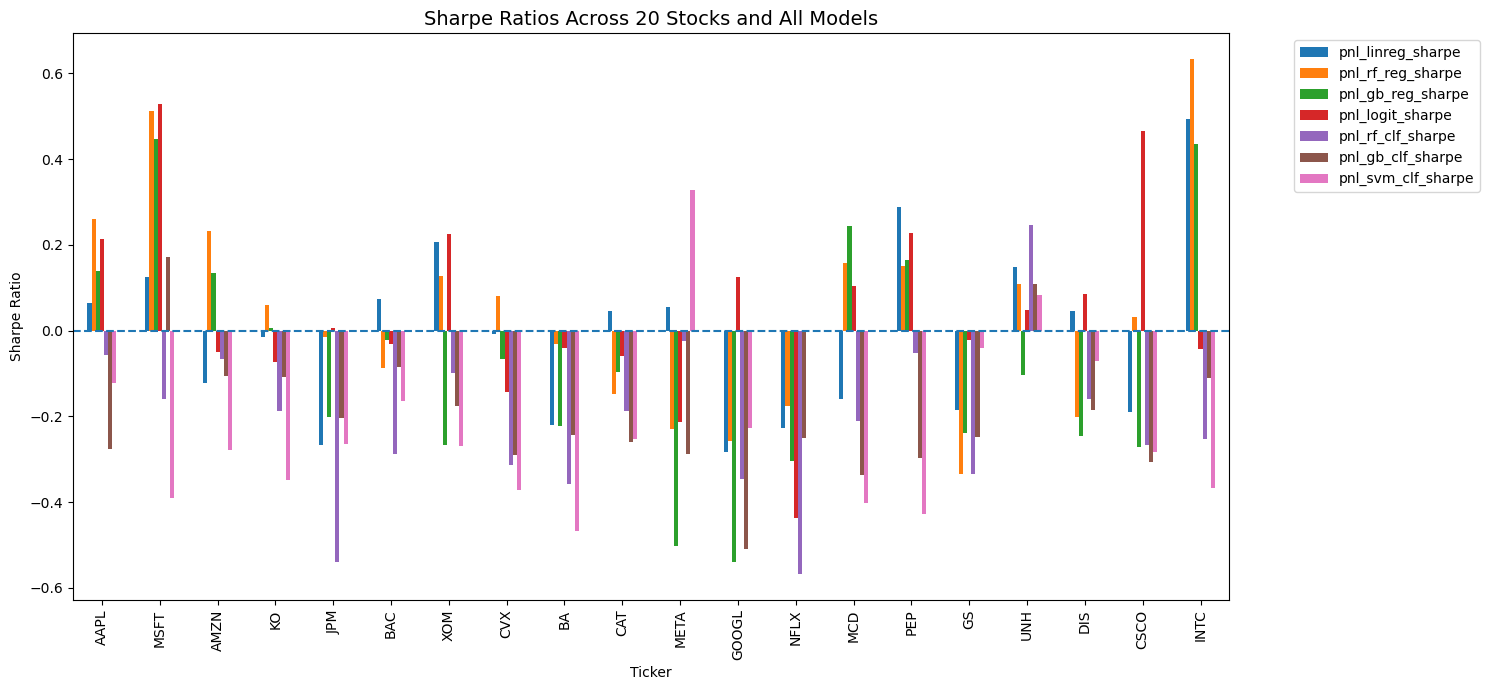

In [37]:
import matplotlib.pyplot as plt

# ---------------------------------
# 1️⃣ Sharpe ratios by ticker/model
# ---------------------------------
plt.figure(figsize=(14, 7))

# Include the new SVM classifier model here 👇
sharpe_cols = [
    "pnl_linreg_sharpe",
    "pnl_rf_reg_sharpe",
    "pnl_gb_reg_sharpe",
    "pnl_logit_sharpe",
    "pnl_rf_clf_sharpe",
    "pnl_gb_clf_sharpe",
    "pnl_svm_clf_sharpe",  # ← NEW
]

combined_results_df[sharpe_cols].plot(kind="bar", figsize=(15, 7))
plt.title("Sharpe Ratios Across 20 Stocks and All Models", fontsize=14)
plt.xlabel("Ticker")
plt.ylabel("Sharpe Ratio")
plt.axhline(0, linestyle="--")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



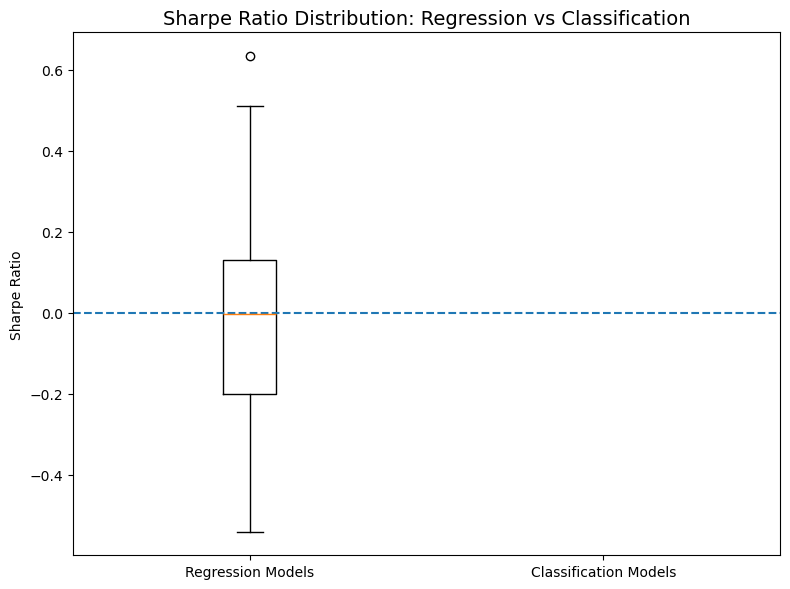

In [39]:
# -------------------------------------------------
# 2️⃣ Boxplot: Regression vs Classification Sharpe
# -------------------------------------------------
reg_cols = [
    "pnl_linreg_sharpe",
    "pnl_ridge_sharpe",
    "pnl_rf_reg_sharpe",
    "pnl_gb_reg_sharpe",
]

cls_cols = [
    "pnl_logit_sharpe",
    "pnl_rf_clf_sharpe",
    "pnl_gb_clf_sharpe",
    "pnl_svm_clf_sharpe",  # ← Added SVM classifier
]

# Flatten all values for grouping
reg_values = combined_results_df[reg_cols].values.flatten()
cls_values = combined_results_df[cls_cols].values.flatten()

plt.figure(figsize=(8, 6))
plt.boxplot([reg_values, cls_values],
            labels=["Regression Models", "Classification Models"])
plt.title("Sharpe Ratio Distribution: Regression vs Classification", fontsize=14)
plt.ylabel("Sharpe Ratio")
plt.axhline(0, linestyle="--")
plt.tight_layout()
plt.show()


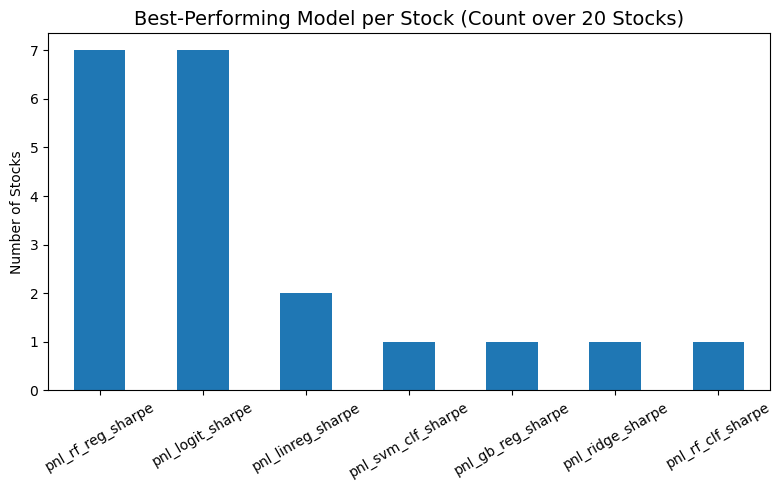

Best model per stock:
                Best Model
ticker                    
AAPL     pnl_rf_reg_sharpe
MSFT      pnl_logit_sharpe
AMZN     pnl_rf_reg_sharpe
KO       pnl_rf_reg_sharpe
JPM       pnl_logit_sharpe
BAC      pnl_linreg_sharpe
XOM       pnl_logit_sharpe
CVX      pnl_rf_reg_sharpe
BA       pnl_rf_reg_sharpe
CAT      pnl_linreg_sharpe
META    pnl_svm_clf_sharpe
GOOGL     pnl_logit_sharpe
NFLX     pnl_rf_reg_sharpe
MCD      pnl_gb_reg_sharpe
PEP       pnl_ridge_sharpe
GS        pnl_logit_sharpe
UNH      pnl_rf_clf_sharpe
DIS       pnl_logit_sharpe
CSCO      pnl_logit_sharpe
INTC     pnl_rf_reg_sharpe


In [41]:
# --------------------------------------------------------
# 3️⃣ Which model wins most often? (simple bar chart)
# --------------------------------------------------------

reg_cols = [
    "pnl_linreg_sharpe",
    "pnl_ridge_sharpe",
    "pnl_rf_reg_sharpe",
    "pnl_gb_reg_sharpe",
]

cls_cols = [
    "pnl_logit_sharpe",
    "pnl_rf_clf_sharpe",
    "pnl_gb_clf_sharpe",
    "pnl_svm_clf_sharpe",   # ← Added SVM classifier
]

# Determine winning model per ticker (highest Sharpe)
best_model_each_stock = combined_results_df[reg_cols + cls_cols].idxmax(axis=1)
model_counts = best_model_each_stock.value_counts()

plt.figure(figsize=(8, 5))
model_counts.plot(kind="bar")
plt.title("Best-Performing Model per Stock (Count over 20 Stocks)", fontsize=14)
plt.ylabel("Number of Stocks")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

print("Best model per stock:")
print(best_model_each_stock.to_frame(name="Best Model"))


In [45]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.svm import SVC
import pandas as pd

# -----------------------------
# Best hyperparameters for AAPL
# -----------------------------
ticker = "AAPL"

# 1) Get data and features (reuse your existing functions)
price_df = download_stooq(ticker)
df_all, X, y_reg, y_cls, ret, feature_cols = feature_engineering(price_df)

dates = pd.DatetimeIndex(df_all.index)
last_date = dates.max()

# Use last 6 years: 5 years train, last 1 year test
train_end = last_date - pd.DateOffset(years=1)
train_start = train_end - pd.DateOffset(years=5)

train_mask = (dates >= train_start) & (dates <= train_end)
test_mask = (dates > train_end)  # not really needed for tuning, but kept for consistency

X_train = X.loc[train_mask, :]
y_reg_train = y_reg[train_mask]
y_cls_train = y_cls[train_mask]

print(f"Train period: {dates[train_mask].min().date()} → {dates[train_mask].max().date()}")
print(f"Train samples: {X_train.shape[0]}")

# 2) Scaling and CV
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

tscv = TimeSeriesSplit(n_splits=3)

# 3) Hyperparameter grids (same as in your walk-forward)
param_grids = {
    "ridge": {
        "alpha": [0.01, 0.1, 1.0, 10.0, 100.0],   # wider range
        "fit_intercept": [True, False],
        "solver": ["auto", "svd", "cholesky", "lsqr"]
    },

    "rf_reg": {
        "n_estimators": [100, 300, 500],
        "max_depth": [3, 6, 9, None],
        "min_samples_leaf": [5, 10, 20],
        "max_features": ["sqrt", "log2", None],
        "bootstrap": [True, False]
    },

    "gb_reg": {
        "n_estimators": [100, 300, 500],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [2, 3, 4],
        "subsample": [0.6, 0.8, 1.0],
        "loss": ["squared_error"]    # new unified name in sklearn ≥1.0
    },

    "logit": {
        "C": [0.01, 0.1, 1.0, 10.0],
        "penalty": ["l2"],   # l1 requires different solver
        "fit_intercept": [True, False],
        "class_weight": [None, "balanced"]
    },

    "rf_clf": {
        "n_estimators": [100, 300, 500],
        "max_depth": [3, 6, 9, None],
        "min_samples_leaf": [5, 10, 20],
        "max_features": ["sqrt", "log2", None],
        "bootstrap": [True, False]
    },

    "gb_clf": {
        "n_estimators": [100, 300, 500],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [2, 3, 4],
        "subsample": [0.6, 0.8, 1.0],
        "loss": ["log_loss"]   # updated for newer sklearn
    },

    "svm": {
        "C": [0.1, 1.0, 10.0, 100.0],
        "gamma": ["scale", "auto"],
        "kernel": ["rbf", "poly"],
        "class_weight": [None, "balanced"]
    }
}

best_params = {}

# ---------- Regression models ----------
# Linear Regression (no hyperparams – just record it)
best_params["linreg"] = {}

# Ridge
ridge_base = Ridge(random_state=42)
ridge_gs = GridSearchCV(
    ridge_base,
    param_grids["ridge"],
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)
ridge_gs.fit(X_train_scaled, y_reg_train)
best_params["ridge"] = ridge_gs.best_params_

# RF Regressor (unscaled)
rf_reg_base = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_reg_gs = GridSearchCV(
    rf_reg_base,
    param_grids["rf_reg"],
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)
rf_reg_gs.fit(X_train, y_reg_train)
best_params["rf_reg"] = rf_reg_gs.best_params_

# GB Regressor (scaled)
gb_reg_base = GradientBoostingRegressor(random_state=42)
gb_reg_gs = GridSearchCV(
    gb_reg_base,
    param_grids["gb_reg"],
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)
gb_reg_gs.fit(X_train_scaled, y_reg_train)
best_params["gb_reg"] = gb_reg_gs.best_params_

# ---------- Classification models ----------
# Logistic Regression (scaled)
logit_base = LogisticRegression(max_iter=1000, solver="lbfgs")
logit_gs = GridSearchCV(
    logit_base,
    param_grids["logit"],
    cv=tscv,
    scoring="accuracy",
    n_jobs=-1,
)
logit_gs.fit(X_train_scaled, y_cls_train)
best_params["logit"] = logit_gs.best_params_

# RF Classifier (unscaled)
rf_clf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf_gs = GridSearchCV(
    rf_clf_base,
    param_grids["rf_clf"],
    cv=tscv,
    scoring="accuracy",
    n_jobs=-1,
)
rf_clf_gs.fit(X_train, y_cls_train)
best_params["rf_clf"] = rf_clf_gs.best_params_

# GB Classifier (scaled)
gb_clf_base = GradientBoostingClassifier(random_state=42)
gb_clf_gs = GridSearchCV(
    gb_clf_base,
    param_grids["gb_clf"],
    cv=tscv,
    scoring="accuracy",
    n_jobs=-1,
)
gb_clf_gs.fit(X_train_scaled, y_cls_train)
best_params["gb_clf"] = gb_clf_gs.best_params_

# SVM Classifier (scaled)
svm_base = SVC(probability=True)
svm_gs = GridSearchCV(
    svm_base,
    param_grids["svm"],
    cv=tscv,
    scoring="accuracy",
    n_jobs=-1,
)
svm_gs.fit(X_train_scaled, y_cls_train)
best_params["svm"] = svm_gs.best_params_

# 4) Display nicely
best_params_df = pd.DataFrame(best_params).T
print("\n=== Best hyperparameters for AAPL (5y train window) ===")
display(best_params_df)


Train period: 2019-12-03 → 2024-12-03
Train samples: 1259

=== Best hyperparameters for AAPL (5y train window) ===


,alpha,fit_intercept,solver,bootstrap,max_depth,max_features,min_samples_leaf,n_estimators,learning_rate,loss,subsample,C,class_weight,penalty,gamma,kernel
linreg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ridge,100.0,False,svd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rf_reg,NaN,NaN,NaN,False,3,log2,20,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gb_reg,NaN,NaN,NaN,NaN,2,NaN,NaN,100,0.01,squared_error,0.8,NaN,NaN,NaN,NaN,NaN
logit,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,balanced,l2,NaN,NaN
rf_clf,NaN,NaN,NaN,False,3,None,5,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gb_clf,NaN,NaN,NaN,NaN,3,NaN,NaN,100,0.01,log_loss,1.0,NaN,NaN,NaN,NaN,NaN
svm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,balanced,NaN,scale,poly


Running MSFT with model=rf_reg, cost=0.0 bps
Running MSFT with model=rf_reg, cost=5.0 bps
Running MSFT with model=rf_reg, cost=10.0 bps


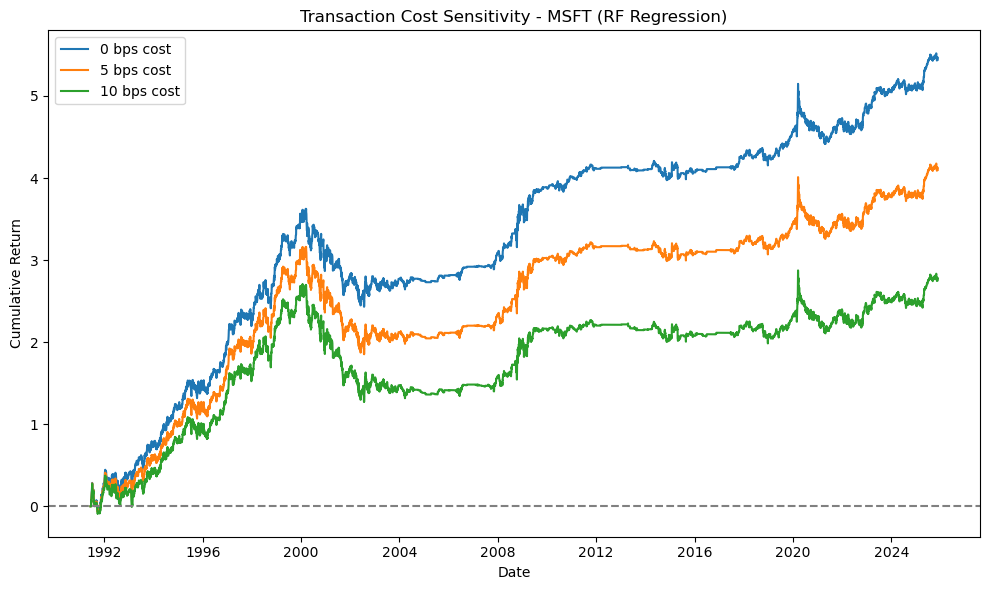

In [49]:
import matplotlib.pyplot as plt

def pnl_sensitivity_analysis(ticker, base_model="rf_reg",
                             cost_values=[0.0, 0.0005, 0.001]):
    """
    Re-run the chosen model for one ticker under different transaction costs.
    Uses the existing rolling_walk_forward() and global cost_per_side.
    
    base_model options:
        "rf_reg"  -> Random Forest Regression
        "lin_reg" -> Linear Regression
        "logit"   -> Logistic Regression (classification)
    """
    # Map model name to key in rolling_walk_forward() results
    model_key_map = {
        "rf_reg": "pnl_rf_reg",
        "lin_reg": "pnl_linreg",
        "logit": "pnl_logit",
    }
    model_key = model_key_map[base_model]

    # Prepare data for this ticker
    price_df = download_stooq(ticker)
    df_all, X, y_reg, y_cls, ret, feature_cols = feature_engineering(price_df)

    curves = {}
    global cost_per_side
    original_cost = cost_per_side  # remember original setting

    for cost in cost_values:
        print(f"Running {ticker} with model={base_model}, cost={cost*1e4:.1f} bps")
        cost_per_side = cost

        res_pnl = rolling_walk_forward(X, y_reg, y_cls, ret, df_all.index)
        pnl_series = res_pnl[model_key]
        curves[cost] = pnl_series.cumsum()

    cost_per_side = original_cost  # restore

    return curves

# Example: MSFT, Random Forest Regression, 0 / 5 / 10 bps
ticker_to_test = "MSFT"
sensitivity_curves = pnl_sensitivity_analysis(
    ticker_to_test,
    base_model="rf_reg",
    cost_values=[0.0, 0.0005, 0.001]
)

# Plot
plt.figure(figsize=(10, 6))
for cost, curve in sensitivity_curves.items():
    plt.plot(curve, label=f"{int(cost*1e4)} bps cost")

plt.axhline(0, linestyle="--", color="gray")
plt.title(f"Transaction Cost Sensitivity - {ticker_to_test} (RF Regression)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.tight_layout()
plt.show()


Running BAC with model=rf_reg, cost=0.0 bps
Running BAC with model=rf_reg, cost=5.0 bps
Running BAC with model=rf_reg, cost=10.0 bps


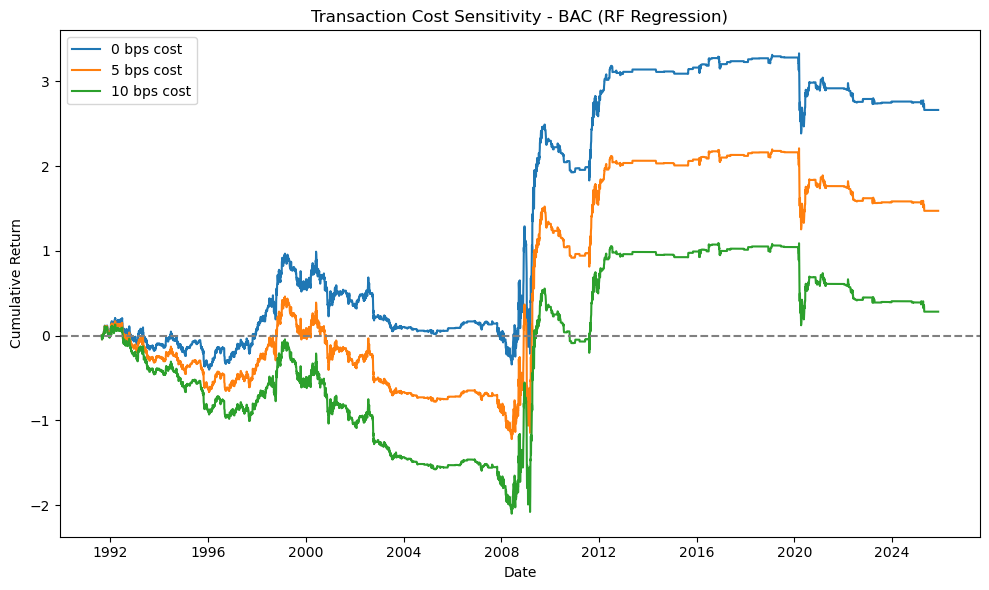

In [51]:
ticker_to_test = "BAC"  # PERFECT example for edge-case behavior

sensitivity_curves = pnl_sensitivity_analysis(
    ticker_to_test,
    base_model="rf_reg",
    cost_values=[0.0, 0.0005, 0.001]
)

plt.figure(figsize=(10,6))
for cost, curve in sensitivity_curves.items():
    plt.plot(curve, label=f"{int(cost*1e4)} bps cost")

plt.axhline(0, linestyle="--", color="gray")
plt.title(f"Transaction Cost Sensitivity - {ticker_to_test} (RF Regression)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.tight_layout()
plt.show()
